In [1]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Model, GPT2ForSequenceClassification, Trainer, TrainingArguments, GPT2Config
import torch
import json
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from tqdm import tqdm
import random

## Read the data

In [2]:
def load_jsonl(filename):
    f = open(filename)
    return [json.loads(line) for line in f.read().splitlines()]

In [3]:
train_examples = load_jsonl("data/train.jsonl")
dev_examples = load_jsonl("data/dev.jsonl")
test_examples = load_jsonl("data/test_no_labels.jsonl")

### Split the data into positive and negative samples to provide balanced dataset ( 10 samples for each to get max 20 samples)

In [4]:
def split_neg_pos_examples(examples):
    pos_examples, neg_examples = [],[]
    for eg in examples:
        if eg['label'] == 'True':
            pos_examples.append(eg)
        else:
            neg_examples.append(eg)
    return pos_examples, neg_examples

In [5]:
pos_examples, neg_examples = split_neg_pos_examples(train_examples)
pos_examples = pos_examples[:10]
neg_examples = neg_examples[:10]
train_examples = pos_examples + neg_examples

### Convert data into a form to be input to pytorch Dataset class

In [6]:
def get_text_label(examples):
    text = []
    labels = []
    for eg in examples:
        text.append(eg['text'])
        labels.append(0 if eg['label']=='False' else 1)
    return text, labels

In [7]:
train_texts, train_labels = get_text_label(train_examples)
dev_texts, dev_labels = get_text_label(dev_examples)

In [8]:
test_text = []
for eg in test_examples:
    test_text.append(eg['text'])

### Setup the Transformer and Freeze all the layers except the classification layer

In [9]:
configuration = GPT2Config()
GPT2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
GPT2_tokenizer.pad_token = GPT2_tokenizer.eos_token

model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=2)
model.config.pad_token_id = model.config.eos_token_id

for param in model.transformer.parameters():
    param.requires_grad = False

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Generate tokens for all the examples to be input to the model

In [10]:
train_encodings = GPT2_tokenizer(train_texts, truncation=True, padding=True)
dev_encodings = GPT2_tokenizer(dev_texts, truncation=True, padding=True)

### Create the dataset class

In [11]:
class ArXivpaperDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [12]:
train_dataset = ArXivpaperDataset(train_encodings, train_labels)
dev_dataset = ArXivpaperDataset(dev_encodings, dev_labels)

### Define the training parameters 

The below parameters are set to default value as suggested in the huggingface library

In [17]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1000,              # total number of training epochs
    per_device_train_batch_size=64,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


### Using the huggingface defined trainer class to train the transformer 

In [19]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=dev_dataset             # evaluation dataset
)

### Train for 1000 epochs

In [20]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 20
  Num Epochs = 1000
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1000


Step,Training Loss
10,5.102900
20,4.990700
30,5.109000
40,5.014800
50,5.046500
60,5.144200
70,4.880900
80,4.798200
90,4.915100
100,4.760700


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1000, training_loss=1.4715102481842042, metrics={'train_runtime': 499.4784, 'train_samples_per_second': 40.042, 'train_steps_per_second': 2.002, 'total_flos': 3337657712640000.0, 'train_loss': 1.4715102481842042, 'epoch': 1000.0})

### Generic functions to visualise the output 

In [35]:
def print_metrics(outputs, examples):
    pred = torch.Tensor([0 if out=='LABEL_0' else 1 for out in outputs])
    label = torch.Tensor([0 if out['label']=='False' else 1 for out in examples])
    accuracy = (label==pred).sum() / len(label)
    ConfusionMatrixDisplay.from_predictions(label, pred, display_labels=['Not AI','AI'])
    plt.show()
    report = classification_report(label, pred, target_names=['Not AI','AI'])
    return accuracy, report

In [36]:
def classify(examples):
    pred = []
    for eg in examples:
        txt = eg['text']
        inputs = GPT2_tokenizer(txt, return_tensors="pt")
        inputs = inputs.to("cuda")
        with torch.no_grad():
            logits = model(**inputs).logits

        predicted_class_id = logits.argmax().item()
        pred.append(model.config.id2label[predicted_class_id])
    accuracy, report = print_metrics(pred,examples)
    print("Accuracy = {}".format(str(accuracy)))
    print(report)

In [37]:
train_examples = load_jsonl("data/train.jsonl")

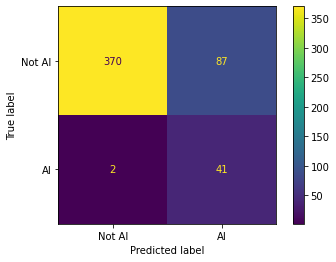

Accuracy = tensor(0.8220)
              precision    recall  f1-score   support

      Not AI       0.99      0.81      0.89       457
          AI       0.32      0.95      0.48        43

    accuracy                           0.82       500
   macro avg       0.66      0.88      0.69       500
weighted avg       0.94      0.82      0.86       500



In [38]:
classify(train_examples)

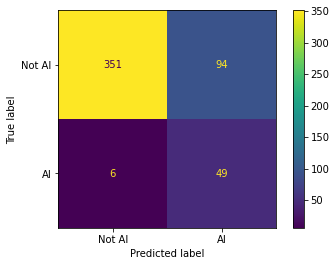

Accuracy = tensor(0.8000)
              precision    recall  f1-score   support

      Not AI       0.98      0.79      0.88       445
          AI       0.34      0.89      0.49        55

    accuracy                           0.80       500
   macro avg       0.66      0.84      0.69       500
weighted avg       0.91      0.80      0.83       500



In [39]:
classify(dev_examples)

#### Best results so far. Better than the prompt classification. Therefore, this model is chosen for classification of the test dataset

### Generate prediction for test dataset and create a new jsonl file with the predictions

In [56]:
test_json = []
for eg in test_examples:
    txt = eg['text']
    inputs = GPT2_tokenizer(txt, return_tensors="pt")
    inputs = inputs.to("cuda")
    with torch.no_grad():
        logits = model(**inputs).logits

    predicted_class_id = logits.argmax().item()
    if model.config.id2label[predicted_class_id] == 'LABEL_0':
        pred = 'False'
    else:
        pred = 'True'
    test_json.append({'label':pred, 'text':txt, 'meta':eg['meta']})

In [57]:
with open("test_prediction.jsonl", 'w') as f:
    for item in test_json:
        f.write(json.dumps(item) + "\n")

### References
#### https://huggingface.co/docs/transformers/training
#### https://huggingface.co/docs/transformers/model_doc/gpt2